In [ ]:
from ase import Atoms
from ase.build import molecule
from ase.io import write, read
import numpy as np
from scipy.spatial.transform import Rotation as R
from tkinter.filedialog import askopenfilename

# CIF 파일에서 셀 크기 읽기
cif_path = askopenfilename(title="Select CIF file", filetypes=[("CIF files", "*.cif")])
slab = read(cif_path)
cell = slab.get_cell()
box_x, box_y, box_z, alpha, beta, gamma = slab.get_cell_lengths_and_angles()

z_surface = 10.0      # 표면 z 위치
z_offset = 3.0        # 표면에서 띄울 높이

# 배치 설정
num_waters = 40
spacing = 2.8  # 물 분자 간 최소 간격
start_z = z_surface + z_offset

# 셀 벡터
a_vec, b_vec, _ = cell[0], cell[1], cell[2]

# 물 분자 정의
water = molecule('H2O')
water.translate(-water.get_center_of_mass())  # 원점 중심화

waters = []
placed = 0
max_i = int(box_x // spacing)
max_j = int(box_y // spacing)
max_k = int((box_z - start_z) // spacing)

for k in range(max_k):
    for j in range(max_j):
        for i in range(max_i):
            if placed >= num_waters:
                break

            # 격자 벡터 기반 위치 생성
            pos_vector = i * spacing * a_vec / np.linalg.norm(a_vec) + \
                         j * spacing * b_vec / np.linalg.norm(b_vec) + \
                         k * spacing * np.array([0, 0, 1]) + \
                         np.array([0, 0, start_z])

            if pos_vector[2] > (box_z - spacing):
                print("Reached top of cell. Stopping placement.")
                break

            new = water.copy()

            # 무작위 회전 적용
            rot = R.random().as_matrix()
            new.positions = np.dot(new.positions, rot.T)

            new.translate(pos_vector)
            waters.append(new)
            placed += 1

# 병합
combined = sum(waters[1:], waters[0].copy()) if waters else Atoms()
combined.set_cell(cell)
combined.set_pbc([True, True, True])

# 저장 (CIF 파일 형식)
write('water_ordered_on_surface.cif', combined)
print(f"{len(combined)} atoms written to 'water_ordered_on_surface.cif'")


In [ ]:
from ase import Atoms
from ase.build import molecule
from ase.io import write, read
import numpy as np
from scipy.spatial.transform import Rotation as R
from tkinter.filedialog import askopenfilename

# CIF 파일에서 셀 parameter 읽기
cif_path = askopenfilename(title="Select CIF file", filetypes=[("CIF files", "*.cif")])
slab = read(cif_path)
cell = slab.get_cell()
box_x, box_y, box_z, alpha, beta, gamma = slab.get_cell_lengths_and_angles()

# slab에서 가장 큰 z 값을 가진 원소 기준으로 z_surface 설정
z_surface = max(slab.positions[:, 2])
z_offset = 3.0  # 표면에서 띄울 높이

# 층 수 입력
num_layers = 3  # 사용자 정의 층 수
min_spacing = 2.4  # 사용자 정의 최소 간격
start_z = z_surface + z_offset

# 셀 벡터
a_vec, b_vec, c_vec = cell[0], cell[1], cell[2]

# i, j 방향으로 최대 분자 수
max_i = int(np.linalg.norm(a_vec) // min_spacing)
max_j = int(np.linalg.norm(b_vec) // min_spacing)

# spacing 재계산 (모든 분자들이 PBC 하에 동일 간격을 갖도록 조정)
adjusted_spacing_x = np.linalg.norm(a_vec) / max_i if max_i > 0 else np.linalg.norm(a_vec)
adjusted_spacing_y = np.linalg.norm(b_vec) / max_j if max_j > 0 else np.linalg.norm(b_vec)

# 시작 위치를 중심 정렬로 재조정
origin_shift_x = (np.linalg.norm(a_vec) - (max_i - 1) * adjusted_spacing_x) / 2 if max_i > 1 else 0
origin_shift_y = (np.linalg.norm(b_vec) - (max_j - 1) * adjusted_spacing_y) / 2 if max_j > 1 else 0

# 물 분자 정의
water = molecule('H2O')
water.translate(-water.get_center_of_mass())  # 원점 중심화

waters = []

for k in range(num_layers):
    for j in range(max_j):
        for i in range(max_i):
            # 격자 벡터 기반 위치 생성
            pos_vector = i * adjusted_spacing_x * a_vec / np.linalg.norm(a_vec) + \
                         j * adjusted_spacing_y * b_vec / np.linalg.norm(b_vec) + \
                         k * min_spacing * np.array([0, 0, 1]) + \
                         origin_shift_x * a_vec / np.linalg.norm(a_vec) + \
                         origin_shift_y * b_vec / np.linalg.norm(b_vec) + \
                         np.array([0, 0, start_z])

            if pos_vector[2] > (box_z - min_spacing):
                print("Reached top of cell. Stopping placement.")
                break

            new = water.copy()

            # 무작위 회전 적용
            rot = R.random().as_matrix()
            new.positions = np.dot(new.positions, rot.T)

            new.translate(pos_vector)
            waters.append(new)

# 병합
combined = sum(waters[1:], waters[0].copy()) if waters else Atoms()
combined += slab  # slab과 결합
combined.set_cell(cell)
combined.set_pbc([True, True, True])

# 저장 (CIF 파일 형식)
write('water_ordered_on_surface.cif', combined)
print(f"{len(combined)} atoms written to 'water_ordered_on_surface.cif'")

In [ ]:
from tkinter.filedialog import askopenfilename
from openbabel import openbabel, pybel

print(pybel.readfile)  # 함수 존재 여부 확인
# .gjf 파일 읽기
mol = next(pybel.readfile("g06", askopenfilename(title="Select GJF file", filetypes=[("GJF files", "*.gjf")])))

# .xyz 파일로 저장
mol.write("xyz", "output.xyz", overwrite=True)


In [ ]:
from ase.io import read, write
from MDAnalysis import Universe

# ASE에서 Cartesian 변환된 XYZ 저장
atoms_1 = read("XDATCAR", index=":")
write("traj.xyz", atoms_1)



In [71]:
from ase.io import read, write
from ase.geometry.cell import cellpar_to_cell
from ase.visualize import view

filename = "CeO2"
n = float(1000)
cif_atoms = read(f"C:\\Users\\Jihoon\\Desktop\\{filename}.cif")
cell = cif_atoms.get_cell()

# 3. XYZ 위치 데이터 읽기 (격자 정보 무시)
frames = read(f"C:\\Users\\Jihoon\\Desktop\\{filename}-pos-1.xyz", index=':')


for atoms_1 in frames:
    atoms_1.set_cell(cell)
    atoms_1.set_pbc([True, True, True])

write(f"C:\\Users\\Jihoon\\Desktop\\{filename}.traj", atoms_1)


In [37]:
from ase.io import read, write

filename = "CeO2"
n = 1000
cif_atoms = read(f"C:\\Users\\Jihoon\\Desktop\\{filename}.cif")
cell = cif_atoms.get_cell()

# 3. XYZ 위치 데이터 읽기 (격자 정보 무시)
frames = read(f"C:\\Users\\Jihoon\\Desktop\\{filename}-pos-1.xyz", index=':')

write(f"C:\\Users\\Jihoon\\Desktop\\{filename}_new.xyz", frames[n:])

In [ ]:
from ase import Atoms
from ase.visualize import view

atoms = Atoms()
atoms.edit()


In [74]:
from ase.io import read
from ase.gui.gui import GUI
from tkinter.filedialog import askopenfilename

def open_file():
    fname = askopenfilename(
        title="Select structure file",
        filetypes=[("All supported files", "*.cif *.xyz *.vasp *.pdb *.traj"),
                   ("All files", "*.*")]
    )
    if not fname:
        print("No file selected.")
        return

    try:
        atoms = read(fname, index=':')
        if not atoms:
            print("No structure(s) found in file.")
            return
    except Exception as e:
        print(f"Failed to read file: {e}")
        return

    gui = GUI(images=atoms)
    gui.run()

open_file()


1.1997259754100955
1.5026159163506725
1.1939174429587263


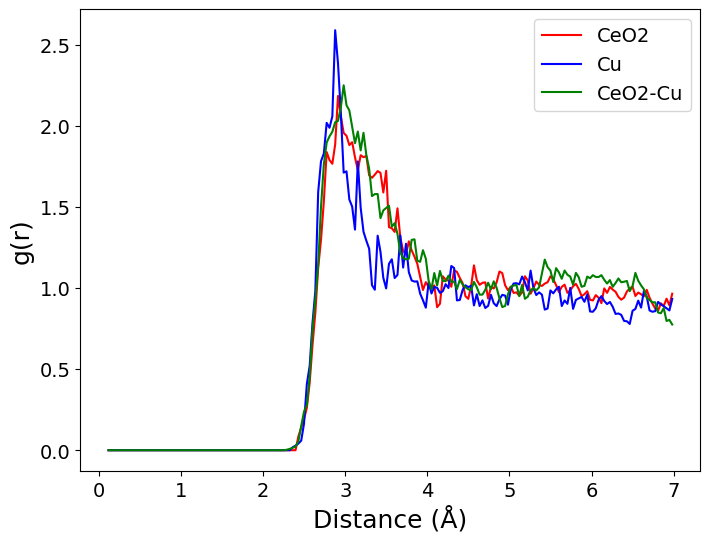

In [25]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read

# CIF 파일 읽기
atoms_1 = read("C:\\Users\\Jihoon\\Desktop\\CeO2.cif")
atoms_2 = read("C:\\Users\\Jihoon\\Desktop\\Cu.cif")
atoms_3 = read("C:\\Users\\Jihoon\\Desktop\\CeO2_Cu.cif")

# 격자 벡터 lengths
cellpar1 = atoms_1.cell.cellpar()
cellpar2 = atoms_2.cell.cellpar()
cellpar3 = atoms_3.cell.cellpar()


# Read trajectory file using MDAnalysis
u1 = mda.Universe("C:\\Users\\Jihoon\\Desktop\\CeO2-pos-1.xyz")
u2 = mda.Universe("C:\\Users\\Jihoon\\Desktop\\Cu-pos-1.xyz")
u3 = mda.Universe("C:\\Users\\Jihoon\\Desktop\\CeO2_Cu-pos-1.xyz")

u1.dimensions = np.array(cellpar1)
u2.dimensions = np.array(cellpar2)
u3.dimensions = np.array(cellpar3)



u1_ag1 = u1.select_atoms('name O and (prop z > 8) and (prop z < 14)')
u2_ag1 = u2.select_atoms('name O')
u3_ag1 = u3.select_atoms('bynum 227:274')


# RDF 계산
rdf1 = InterRDF(u1_ag1, u1_ag1, nbins=200, range=(0.1, 7.0), norm="density")
rdf1.run(start=500, stop=1200, step=1)

rdf2 = InterRDF(u2_ag1, u2_ag1, nbins=200, range=(0.1, 7.0), norm="density")
rdf2.run(start=1000, stop=2000, step=1)

rdf3 = InterRDF(u3_ag1, u3_ag1, nbins=200, range=(0.1, 7.0), norm="density")
rdf3.run(start=500, stop=1500, step=1)

print(rdf1.rdf[99])
print(rdf2.rdf[99])
print(rdf3.rdf[99])

# 결과 시각화
plt.figure(figsize=(8,6))
plt.plot(rdf1.bins, rdf1.rdf / rdf1.rdf[150], label='CeO2', color='red')
plt.plot(rdf2.bins, rdf2.rdf / rdf2.rdf[150], label='Cu', color='blue')
plt.plot(rdf3.bins, rdf3.rdf / rdf3.rdf[150], label='CeO2-Cu', color='green')


#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')
plt.show()

7.15625


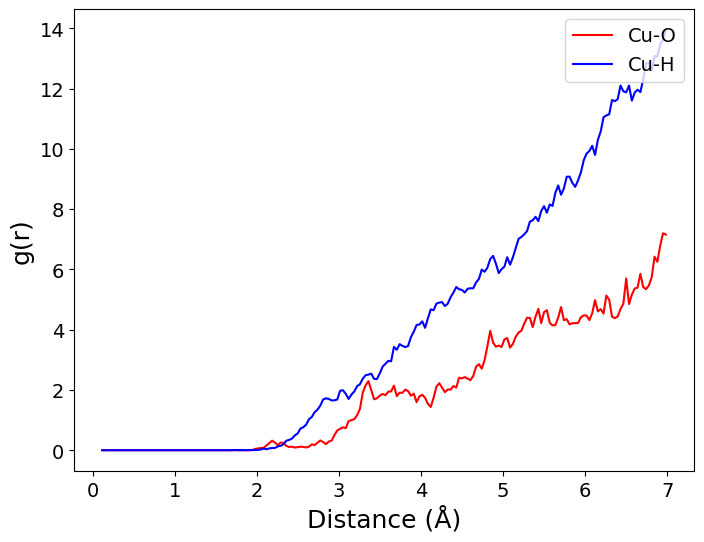

In [34]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
from ase.io import read

# CIF 파일 읽기
atoms_1 = read("C:\\Users\\Jihoon\\Desktop\\Cu.cif")

# 격자 벡터 lengths
cellpar1 = atoms_1.cell.cellpar()


u1 = mda.Universe("C:\\Users\\Jihoon\\Desktop\\Cu-pos-1.xyz")
u1.dimensions = np.array(cellpar1)


u1_ag_O = u1.select_atoms('name O and (prop z < 12)')
u1_ag_H = u1.select_atoms("name H and (prop z < 12)")
u1_ag_Cu = u1.select_atoms("name Cu and (prop z > 5)")


# RDF 계산
rdf1 = InterRDF(u1_ag_Cu, u1_ag_O, nbins=200, range=(0.1, 7.0), norm="none")
rdf2 = InterRDF(u1_ag_Cu, u1_ag_H, nbins=200, range=(0.1, 7.0), norm="none")
rdf1.run(start=500, stop=1300, step=1)
rdf2.run(start=500, stop=1300, step=1)


print(rdf1.rdf[199])


# 결과 시각화
plt.figure(figsize=(8,6))
plt.plot(rdf1.bins, rdf1.rdf, label='Cu-O', color='red')
plt.plot(rdf2.bins, rdf2.rdf, label='Cu-H', color='blue')


#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')
plt.show()

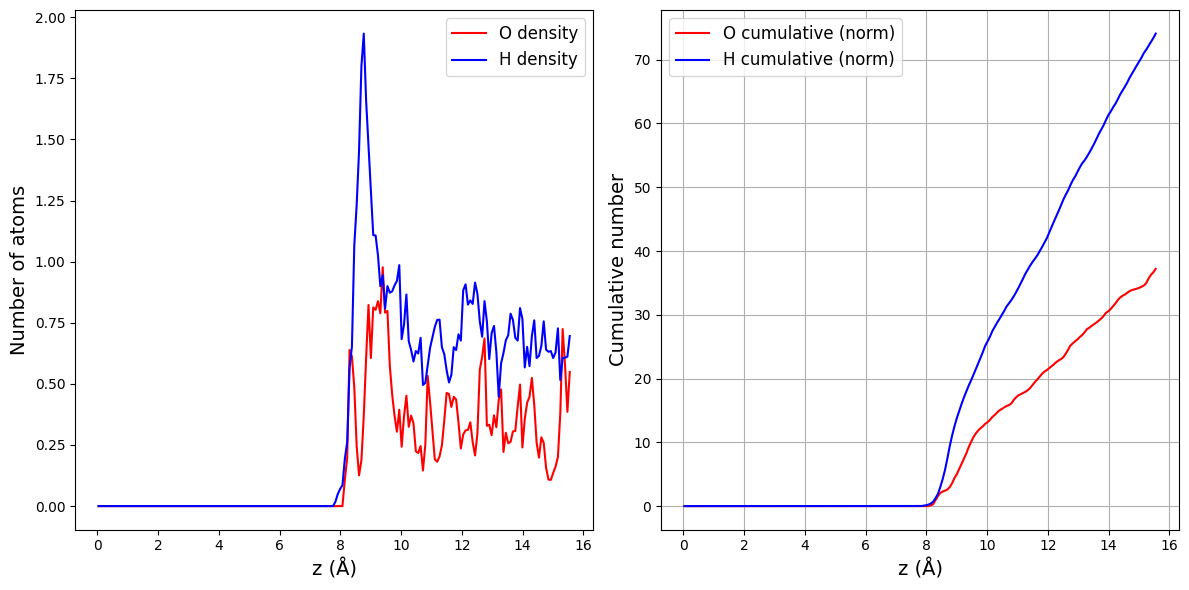

In [26]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

u1 = mda.Universe("C:\\Users\\Jihoon\\Desktop\\Cu-pos-1.xyz")
O_atoms = u1.select_atoms('name O')
H_atoms = u1.select_atoms('name H')

# Trajectory frame 범위 설정
start = 500
stop = 1200
step = 1

# 분석 구간, bin 개수 등 설정
z_min = np.min(u1.atoms.positions[:,2])
z_max = np.max(u1.atoms.positions[:,2])
nbins = 200
z_bins = np.linspace(z_min, z_max, nbins+1)
o_hist = np.zeros(nbins)
h_hist = np.zeros(nbins)
total_frames = 0

for ts in u1.trajectory[start:stop:step]:
    o_z = O_atoms.positions[:,2]
    h_z = H_atoms.positions[:,2]
    o_hist += np.histogram(o_z, bins=z_bins)[0]
    h_hist += np.histogram(h_z, bins=z_bins)[0]
    total_frames += 1

# 평균화 (프레임 수로 나눔)
o_hist = o_hist / total_frames
h_hist = h_hist / total_frames

# CDF 계산 (누적합)
o_cdf = np.cumsum(o_hist)
h_cdf = np.cumsum(h_hist)
# 정규화 (0~1 구간) - 전체 누적 분율로 보고 싶으면 아래 주석 해제
o_cdf_norm = o_cdf / o_cdf[-1]
h_cdf_norm = h_cdf / h_cdf[-1]

# 각 bin의 중심 좌표
z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(z_centers, o_hist, label='O density', color='red')
plt.plot(z_centers, h_hist, label='H density', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Number of atoms', fontsize=14)
plt.legend(fontsize=12)

plt.subplot(1,2,2)
plt.plot(z_centers, o_cdf, label='O cumulative (norm)', color='red')
plt.plot(z_centers, h_cdf, label='H cumulative (norm)', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Cumulative number', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


Total frames: 1307
Number of O atoms: 75
Frame: 0 First O atom z: 9.1620455
Frame: 1 First O atom z: 9.162685
Frame: 2 First O atom z: 9.16296
Frame: 3 First O atom z: 9.162833
Frame: 4 First O atom z: 9.162479
Frame: 5 First O atom z: 9.162125
Frame: 6 First O atom z: 9.161911
Frame: 7 First O atom z: 9.161862
Frame: 8 First O atom z: 9.161923
Frame: 9 First O atom z: 9.162009


100%|██████████| 75/75 [00:00<00:00, 1773.57it/s]

[-8.34309806e-11  1.16949698e-04  4.67054117e-04 ...  6.03724827e+01
  6.03984397e+01  6.04237953e+01]


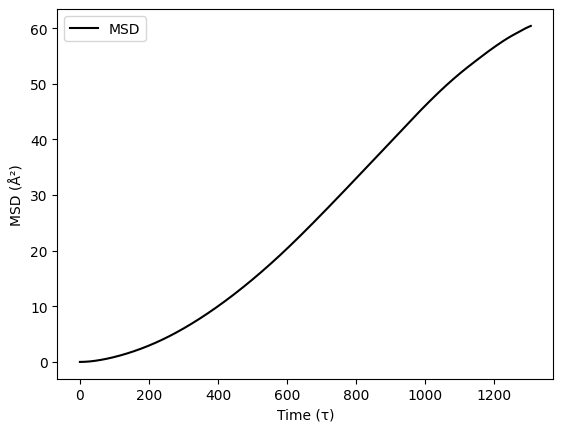

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.msd import EinsteinMSD

# Universe 객체 생성
name = "Cu"
path = "C:\\Users\\Jihoon\\Desktop\\"
cif_name = f"{path}{name}.cif"
xyz_name = f"{path}{name}-pos-1.xyz"


u = mda.Universe(xyz_name)
u1_ag_O_all = u.select_atoms('name O')

print("Total frames:", len(u.trajectory))
O_atoms = u.select_atoms('name O and (prop z > 9)')
print("Number of O atoms:", len(O_atoms))
for ts in u.trajectory[:10]:   # 처음 5 프레임만 예시로
    print("Frame:", ts.frame, "First O atom z:", O_atoms.positions[0][2])


# MSD 분석 수행
msd_analysis = EinsteinMSD(u1_ag_O_all, select="all", msd_type='xyz', fft=True)
msd_analysis.run()

# 결과 추출
msd = msd_analysis.results.timeseries
print(msd)
# 시뮬레이션 파라미터
nframes = msd_analysis.n_frames
timestep = 1  # 프레임 간 시간 간격을 실제 시뮬레이션 값으로 설정하세요
lagtimes = np.arange(nframes) * timestep

# MSD 플롯
plt.figure()
plt.plot(lagtimes, msd, color='black', linestyle='-', label='MSD')
#plt.plot(lagtimes, lagtimes * 6, color='black', linestyle='--', label='y=6τ')
plt.xlabel('Time (τ)')
plt.ylabel('MSD (Å²)')
plt.legend()
plt.show()


In [1]:
from ase.io import read
import numpy as np

name = "CeO2"
path = "C:\\Users\\Jihoon\\Desktop\\"
cif_name = f"{path}{name}.cif"

atoms = read(cif_name)

# Ce 원자 index, z 좌표 추출
ce_indices = [i for i, atom in enumerate(atoms) if atom.symbol == 'Ce']
ce_zs = np.array([atoms[i].position[2] for i in ce_indices])

# 가장 높은 z, 가장 낮은 z 추출 (외곽)
z_tol = 1
z_max = np.max(ce_zs)
z_min = np.min(ce_zs)

print(z_max)
print(z_min)
# tolerance 범위 내 원자 그룹 선택
upper_ce = [ce_indices[i] for i, z in enumerate(ce_zs) if abs(z - z_max) < z_tol]
lower_ce = [ce_indices[i] for i, z in enumerate(ce_zs) if abs(z - z_min) < z_tol]

# index 1-based (CIF/XYZ 기준)
upper_ce_idx = [i+1 for i in upper_ce]
lower_ce_idx = [i+1 for i in lower_ce]

print("Uppermost Ce atom indices:", upper_ce_idx)
print("Lowermost Ce atom indices:", lower_ce_idx)


10.200955762
0.78487807
Uppermost Ce atom indices: [5, 9, 10, 13, 17, 24, 32, 36, 37, 40, 42, 43, 48, 56, 60, 63]
Lowermost Ce atom indices: [1, 4, 8, 12, 16, 20, 23, 27, 28, 30, 33, 44, 51, 55, 59, 64]


C:\Users\Jihoon\AppData\Roaming\Python\Python312\site-packages\MDAnalysis\analysis\base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time


0.33836855480426403


C:\Users\Jihoon\AppData\Roaming\Python\Python312\site-packages\MDAnalysis\analysis\rdf.py:369: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
C:\Users\Jihoon\AppData\Roaming\Python\Python312\site-packages\MDAnalysis\analysis\rdf.py:359: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


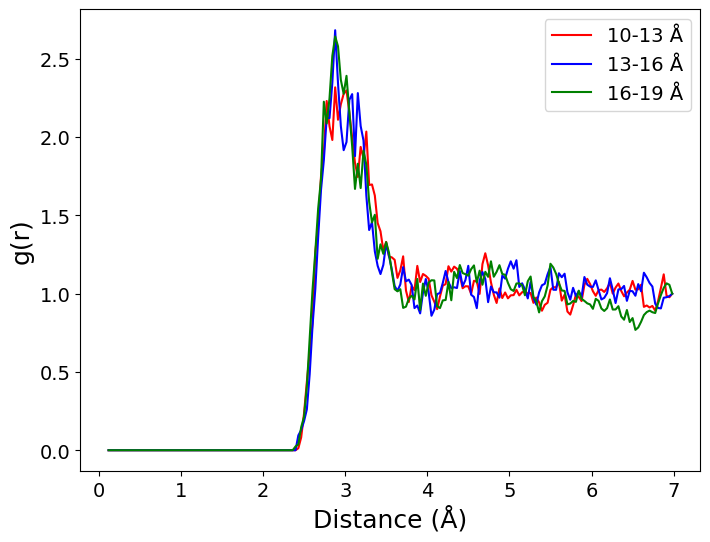

In [50]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
from ase.io import read


name = "CeO2"
path = "C:\\Users\\Jihoon\\Desktop\\"
cif_name = f"{path}{name}.cif"
xyz_name = f"{path}{name}_new.xyz"
start_frame = 1
end_frame = 1000

atoms_1 = read(cif_name)
cellpar1 = atoms_1.cell.cellpar()


u1 = mda.Universe(xyz_name)
u1.dimensions = np.array(cellpar1)


u1_ag_O = u1.select_atoms('name O and (prop z > 10) and (prop z <= 13)')
u2_ag_O = u1.select_atoms('name O and (prop z > 13) and (prop z <= 16)')
u3_ag_O = u1.select_atoms('name O and (prop z > 16) and (prop z <= 19)')
u1_ag_O_all = u1.select_atoms('name O and (prop z > 10)')

# RDF 계산

rdf1 = InterRDF(u1_ag_O, u1_ag_O_all, nbins=200, range=(0.1, 7.0), norm="density")
rdf1.run(start=start_frame, stop=end_frame, step=1)

rdf2 = InterRDF(u2_ag_O, u1_ag_O_all, nbins=200, range=(0.1, 7.0), norm="density")
rdf2.run(start=start_frame, stop=end_frame, step=1)

rdf3 = InterRDF(u3_ag_O, u1_ag_O_all, nbins=200, range=(0.1, 7.0), norm="density")
rdf3.run(start=start_frame, stop=end_frame, step=1)


print(rdf1.rdf[99])


# 결과 시각화
plt.figure(figsize=(8,6))
plt.plot(rdf1.bins, rdf1.rdf / rdf1.rdf[199], label='10-13 Å', color='red')
plt.plot(rdf2.bins, rdf2.rdf / rdf2.rdf[199], label='13-16 Å', color='blue')
plt.plot(rdf3.bins, rdf3.rdf / rdf3.rdf[199], label='16-19 Å', color='green')


#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('g(r)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')
plt.show()

Total frames: 1001
Number of O atoms: 75
Frame: 0 First O atom z: 12.154612
Frame: 1 First O atom z: 12.15536
Frame: 2 First O atom z: 12.155053
Frame: 3 First O atom z: 12.154624
Frame: 4 First O atom z: 12.155241
Frame: 5 First O atom z: 12.157537
Frame: 6 First O atom z: 12.161032
Frame: 7 First O atom z: 12.164631
Frame: 8 First O atom z: 12.167355
Frame: 9 First O atom z: 12.168635


100%|██████████| 150/150 [00:00<00:00, 3017.53it/s]

[-8.98338233e-11  1.07010504e-03  4.16357905e-03 ...  1.30679236e+01
  1.30795807e+01  1.30907413e+01]


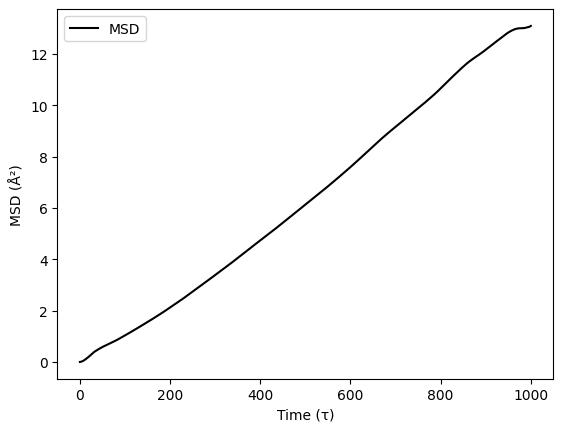

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.msd import EinsteinMSD

# Universe 객체 생성
name = "CeO2"
path = "C:\\Users\\Jihoon\\Desktop\\"
cif_name = f"{path}{name}.cif"
xyz_name = f"{path}{name}_new.xyz"


u = mda.Universe(xyz_name, xyz_name)
u1_ag_O_all = u.select_atoms('name H')

print("Total frames:", len(u.trajectory))
O_atoms = u.select_atoms('name O and (prop z > 9)')
print("Number of O atoms:", len(O_atoms))
for ts in u.trajectory[:10]:   # 처음 5 프레임만 예시로
    print("Frame:", ts.frame, "First O atom z:", O_atoms.positions[0][2])


# MSD 분석 수행
msd_analysis = EinsteinMSD(u1_ag_O_all, select="all", msd_type='xyz', fft=True)
msd_analysis.run()

# 결과 추출
msd = msd_analysis.results.timeseries
print(msd)
# 시뮬레이션 파라미터
nframes = msd_analysis.n_frames
timestep = 1  # 프레임 간 시간 간격을 실제 시뮬레이션 값으로 설정하세요
lagtimes = np.arange(nframes) * timestep

# MSD 플롯
plt.figure()
plt.plot(lagtimes, msd, color='black', linestyle='-', label='MSD')
#plt.plot(lagtimes, lagtimes * 6, color='black', linestyle='--', label='y=6τ')
plt.xlabel('Time (τ)')
plt.ylabel('MSD (Å²)')
plt.legend()
plt.show()


C:\Users\Jihoon\AppData\Roaming\Python\Python312\site-packages\MDAnalysis\analysis\base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time


0.7687687687687688


C:\Users\Jihoon\AppData\Roaming\Python\Python312\site-packages\MDAnalysis\analysis\rdf.py:369: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
C:\Users\Jihoon\AppData\Roaming\Python\Python312\site-packages\MDAnalysis\analysis\rdf.py:359: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


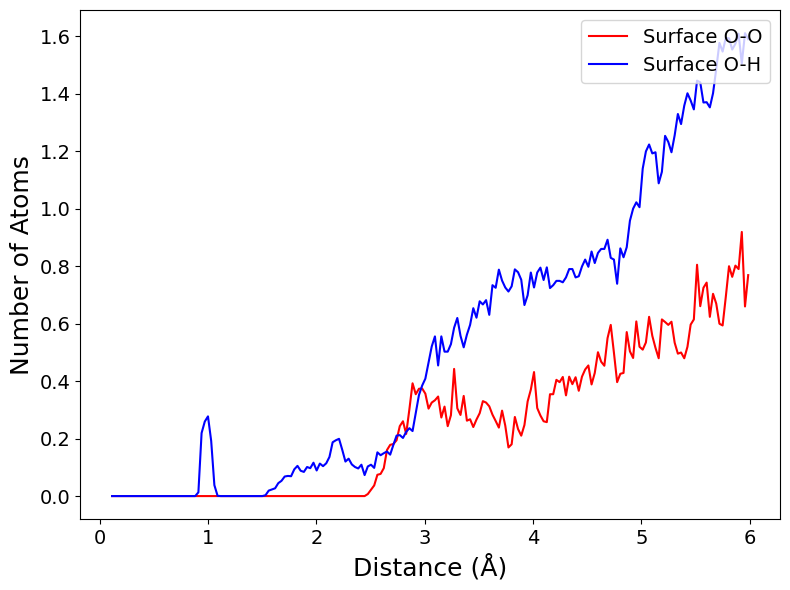

In [55]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog
from ase.io import read


name = "CeO2"
path = "C:\\Users\\Jihoon\\Desktop\\"
cif_name = f"{path}{name}.cif"
xyz_name = f"{path}{name}_new.xyz"

atoms_1 = read(cif_name)
cellpar1 = atoms_1.cell.cellpar()


u1 = mda.Universe(xyz_name)
u1.dimensions = np.array(cellpar1)

u1_ag_Ce = u1.select_atoms("prop z > 7 and (name Ce)")
u1_ag_surface_O = u1.select_atoms('prop z > 10 and (prop z < 11) and (name O) ')
u1_ag_H = u1.select_atoms("name H and (prop z > 11) and (prop z < 15)")
u1_ag_O = u1.select_atoms('name O and (prop z > 11) and (prop z < 15)')


# RDF 계산
rdf1 = InterRDF(u1_ag_surface_O, u1_ag_O, nbins=200, range=(0.1, 6.0), norm="none")
rdf2 = InterRDF(u1_ag_surface_O, u1_ag_H, nbins=200, range=(0.1, 6.0), norm="none")
rdf3 = InterRDF(u1_ag_Ce, u1_ag_O, nbins=200, range=(0.1, 6.0), norm="none")
rdf4 = InterRDF(u1_ag_Ce, u1_ag_H, nbins=200, range=(0.1, 6.0), norm="none")
rdf1.run(start=1, stop=1000, step=1)
rdf2.run(start=1, stop=1000, step=1)
rdf3.run(start=1, stop=1000, step=1)
rdf4.run(start=1, stop=1000, step=1)


print(rdf1.rdf[199])


# 결과 시각화
plt.figure(figsize=(8,6))
#plt.subplot(1,2,1)
plt.plot(rdf1.bins, rdf1.rdf, label='Surface O-O', color='red')
plt.plot(rdf2.bins, rdf2.rdf, label='Surface O-H', color='blue')
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Distance (Å)', fontsize=18)
plt.ylabel('Number of Atoms', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.xlim(-0.2, 6)
#plt.ylim(-0.2, 4.8)
#plt.subplot(1,2,2)
#plt.plot(rdf3.bins, rdf3.rdf, label='Surface Ce-O', color='red')
#plt.plot(rdf4.bins, rdf4.rdf, label='Surface Ce-H', color='blue')
#plt.legend(fontsize=14, loc='upper right')
#plt.xlabel('Distance (Å)', fontsize=18)
#plt.ylabel('Number of Atoms', fontsize=18)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.title('Radial Distribution Function',fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

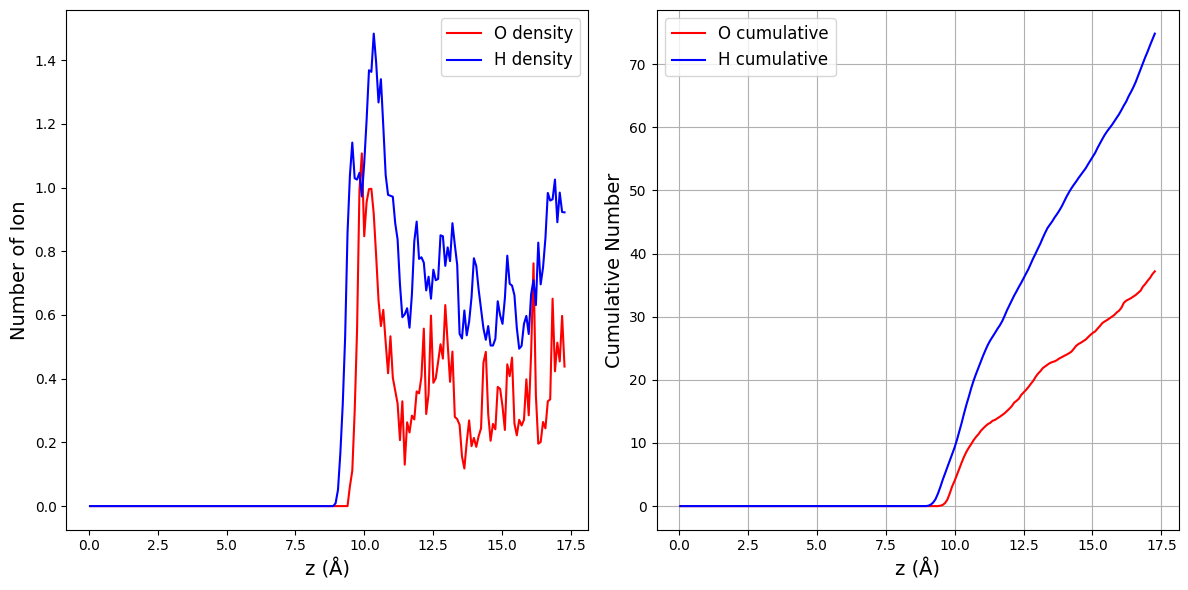

In [12]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

u1 = mda.Universe("C:\\Users\\Jihoon\\Desktop\\CeO2-pos-1.xyz")
O_atoms = u1.select_atoms('name O and (prop z > 9)')
H_atoms = u1.select_atoms('name H')

# Trajectory frame 범위 설정
start = 1000
stop  = 2000
step  = 1

# 분석 구간, bin 개수 등 설정
z_min = np.min(u1.atoms.positions[:,2])
z_max = np.max(u1.atoms.positions[:,2])
nbins = 200
z_bins = np.linspace(z_min, z_max, nbins+1)
o_hist = np.zeros(nbins)
h_hist = np.zeros(nbins)
total_frames = 0

for ts in u1.trajectory[start:stop:step]:
    o_z = O_atoms.positions[:,2]
    h_z = H_atoms.positions[:,2]
    o_hist += np.histogram(o_z, bins=z_bins)[0]
    h_hist += np.histogram(h_z, bins=z_bins)[0]
    total_frames += 1

# 평균화 (프레임 수로 나눔)
o_hist = o_hist / total_frames
h_hist = h_hist / total_frames

# CDF 계산 (누적합)
o_cdf = np.cumsum(o_hist)
h_cdf = np.cumsum(h_hist)
# 정규화 (0~1 구간) - 전체 누적 분율로 보고 싶으면 아래 주석 해제
o_cdf_norm = o_cdf / o_cdf[-1]
h_cdf_norm = h_cdf / h_cdf[-1]

# 각 bin의 중심 좌표
z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(z_centers, o_hist, label='O density', color='red')
plt.plot(z_centers, h_hist, label='H density', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Number of Ion', fontsize=14)
plt.legend(fontsize=12)

plt.subplot(1,2,2)
plt.plot(z_centers, o_cdf, label='O cumulative', color='red')
plt.plot(z_centers, h_cdf, label='H cumulative', color='blue')
plt.xlabel('z (Å)', fontsize=14)
plt.ylabel('Cumulative Number', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


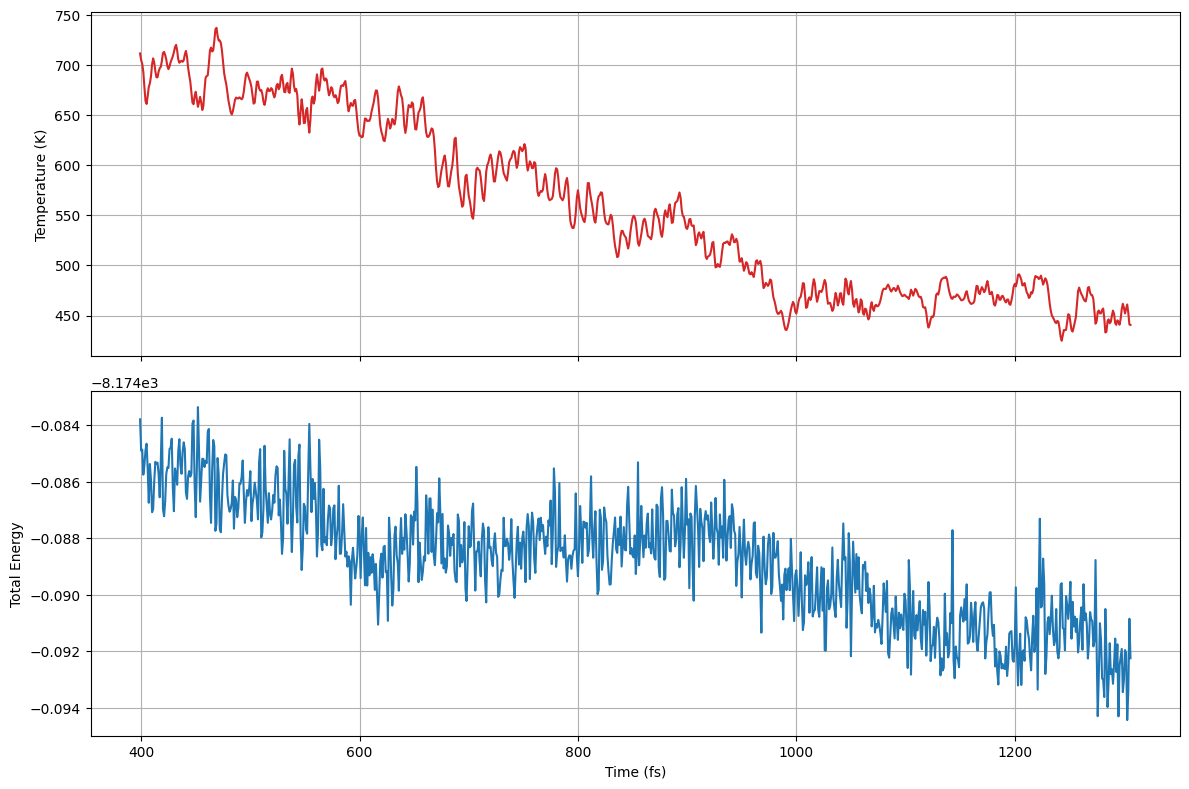

In [7]:
import numpy as np
import matplotlib.pyplot as plt

ener_file = "C:\\Users\\Jihoon\\Desktop\\Cu-1.ener"

# columns: 0=md_step, 1=time_fs, 2=e_kin, 3=temp, 4=e_pot, 5=e_tot, 6=cpu_time

data = np.loadtxt(ener_file, comments='#', skiprows=400, usecols=(1, 3, 5))
time_fs, temp, e_tot = data[:,0], data[:,1], data[:,2]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 위: 온도
axes[0].plot(time_fs, temp, lw=1.5, color='tab:red')
axes[0].set_ylabel('Temperature (K)')
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].grid(True)

# 아래: 에너지
axes[1].plot(time_fs, e_tot, lw=1.5, color='tab:blue')
axes[1].set_xlabel('Time (fs)')
axes[1].set_ylabel('Total Energy')
axes[1].ticklabel_format(style='plain', axis='y')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
csv_file = "C:\\Users\\Jihoon\\Desktop\\CeO2_Cu-1_energy.csv"
np.savetxt(
    csv_file, 
    np.column_stack((time_fs, property)), 
    delimiter=',', 
    header='time_fs,energy', 
    comments='',
    fmt='%.8f' 
)

LOPOT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

# CHGCAR 파일 경로와 축 방향 설정
chgcar_file = 'CHGCAR'  # CHGCAR 파일 경로
axis = 'z'  # 'x', 'y', 또는 'z' 축 방향 선택

# CHGCAR 파일 읽기
atoms_1 = read(chgcar_file, format='vasp')

# 전하 밀도 정보 얻기
charge_density = atoms_1.get_array('charge')  # 'charge'는 VASP 전하 밀도 정보가 저장된 배열

# 격자 정보 얻기
cell = atoms_1.cell
grid_points = charge_density.shape  # 전하 밀도 그리드의 차원 (nx, ny, nz)

# 각 축에 대해 평균 내기
if axis == 'x':
    averaged_density = np.mean(charge_density, axis=0)
    xlabel = 'Y-axis'
    ylabel = 'Z-axis'
elif axis == 'y':
    averaged_density = np.mean(charge_density, axis=1)
    xlabel = 'X-axis'
    ylabel = 'Z-axis'
elif axis == 'z':
    averaged_density = np.mean(charge_density, axis=2)
    xlabel = 'X-axis'
    ylabel = 'Y-axis'
else:
    raise ValueError("axis must be one of ['x', 'y', 'z']")

plt.figure(figsize=(8, 6))
plt.plot(averaged_density)
plt.xlabel(f'{xlabel} direction')
plt.ylabel('Averaged charge density')
plt.title(f'Charge density averaged along {axis}-axis')
plt.grid(True)
plt.show()

DOS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

# DOSCAR 파일 읽기
doscar = read("DOSCAR", format="vasp")

# DOS 데이터를 추출
energies = doscar[0].arrays['energy']  # 에너지 값
dos = doscar[0].arrays['dos']          # DOS 값

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(energies, dos)
plt.xlabel('Energy (eV)')
plt.ylabel('Density of States (DOS)')
plt.title('Density of States (DOS) from DOSCAR')
plt.grid(True)
plt.show()

# Fermi 에너지 기준으로 이동
fermi_energy = doscar[0].arrays['fermi']  # Fermi 에너지
energies -= fermi_energy  # Fermi 에너지를 기준으로 에너지 값 이동

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(energies, dos)
plt.axvline(x=0, color='r', linestyle='--', label=f'Fermi Energy ({fermi_energy} eV)')
plt.xlabel('Energy (eV)')
plt.ylabel('Density of States (DOS)')
plt.title('Density of States (DOS) from DOSCAR')
plt.legend()
plt.grid(True)
plt.show()
